In [10]:
%matplotlib inline
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt

In [2]:
# propeller class

class Propeller:
    direction = None
    speed = 0
    target_speed = 0
    max_speed = 1000
    min_speed = 0
    max_thrust = 140 # 140 N
    speed_increase_rate = 40
    
    def __init__(self, direction):
        self.direction = direction

    def update(self, dt):
        error = self.target_speed - self.speed
        self.speed += error * self.speed_increase_rate * dt
        # self.speed += error / 0.025 * dt
        if self.speed > self.max_speed:
            self.speed = self.max_speed
        elif self.speed < self.min_speed:
            self.speed = self.min_speed

    def set_speed(self, speed):
        if speed > self.max_speed:
            speed = self.max_speed
        elif speed < self.min_speed:
            speed = self.min_speed
        
        self.target_speed = speed

    # thrust in N (Newton)
    def get_thrust(self):
        # return self.speed * self.max_thrust / self.max_speed
        return ((self.speed / self.max_speed) ** 2) * self.max_thrust

    # get torque in N-m (Newton-meter)
    def get_torque(self):
        return self.speed * self.direction * 2 / self.max_speed
        

In [3]:
# Balance Arm
class BalanceArm:
    delta_time = 0.02 # 20ms
    arm_length = 0.2 # 0.3 m = 30 cm
    mass = 0.1 # 0.1Kg
    moment_of_inertia = 1/12 * mass * (arm_length * 2) ** 2
    props = [
        Propeller(1),
        Propeller(-1)
    ]

    target_angle = 0
    angle = 0
    angular_velocity = 0
    

    kp = 20 #10
    ki = 0.1 #0.1 #0.1
    kd = 1.6 #0.5 #1.2
    pid_i = 0
    prev_error = 0

    def update(self):
        error = self.target_angle - self.angle
        pid_p = self.kp * error
        delta_error = error - self.prev_error
        self.prev_error = error
        if abs(delta_error) < 2:
            self.pid_i += self.ki * error * self.delta_time
        else:
            self.pid_i = 0
            
        pid_d = self.kd * delta_error / self.delta_time
        pid = pid_p + self.pid_i + pid_d
        # pid *= 0.001 # converting to PWM
        
        # self.props[0].set_speed(self.props[0].target_speed - pid)
        # self.props[1].set_speed(self.props[1].target_speed + pid)
        self.props[0].set_speed(100 - pid)
        self.props[1].set_speed(100 + pid)
        

        # calculate physics
        # ------------------------------------------------------
        # update angle
        net_torque = self.props[0].get_thrust() * self.arm_length * -1 + self.props[1].get_thrust() * self.arm_length * 1
        # self.angle += net_torque * self.delta_time * 10
        angular_acceleration = net_torque / self.moment_of_inertia
        self.angular_velocity = self.angular_velocity + angular_acceleration * self.delta_time
        if abs(self.angular_velocity) > 300:
            direction = 1
            if self.angular_velocity < 0:
                direction = -1
            self.angular_velocity = 300 * direction
        self.angle = self.angle + self.angular_velocity * self.delta_time
        
        for p in self.props:
            p.update(self.delta_time)
        

    def set_target_angle(self, angle):
        angle %= 360
        angle += 360
        angle %= 360
        self.target_angle = angle

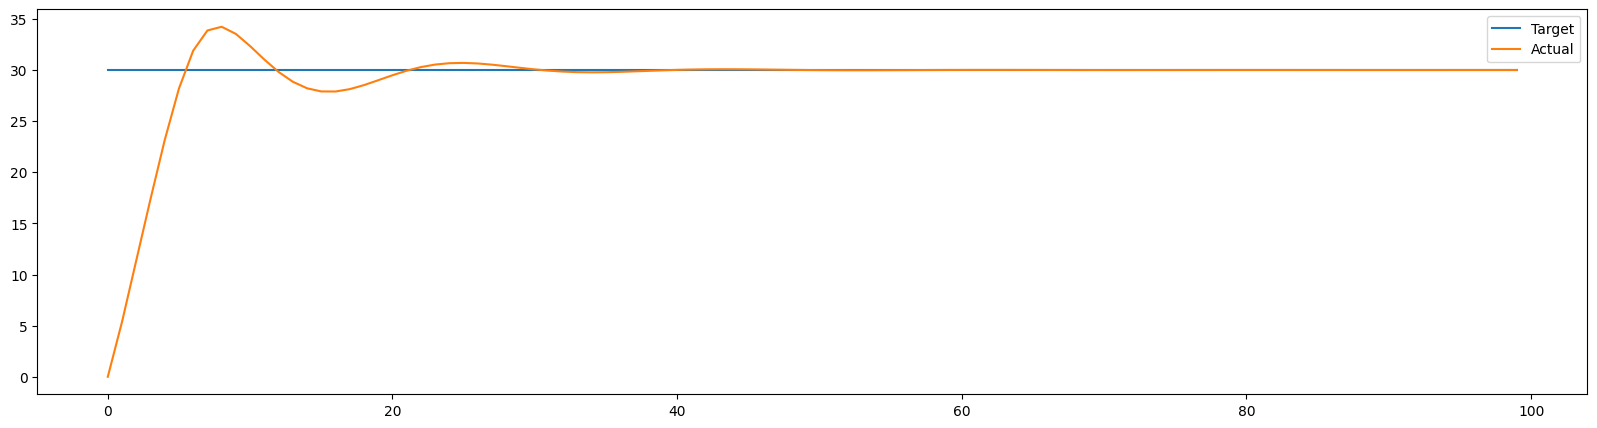

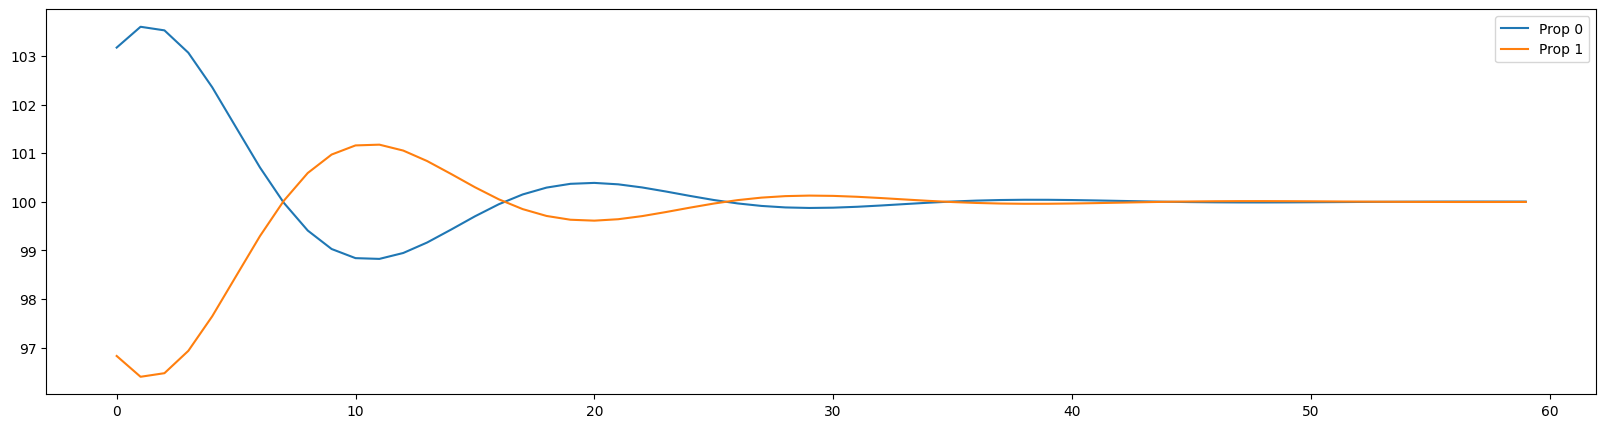

In [4]:
arm = BalanceArm()
arm.set_target_angle(30)
data = []
prop_speed = []
for i in range(100):
    arm.update()
    data.append([arm.target_angle, arm.angle, arm.angular_velocity])
    prop_speed.append([arm.props[0].speed, arm.props[1].speed])
data = np.array(data)
prop_speed = np.array(prop_speed)

plt.figure(figsize=(20, 5))
plt.plot(data[:,0])
plt.plot(data[:,1])
# plt.plot(data[:,2])
plt.legend(['Target', 'Actual', 'Angular velocity'])
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(prop_speed[40:,0])
plt.plot(prop_speed[40:,1])
plt.legend(['Prop 0', 'Prop 1'])
plt.show()

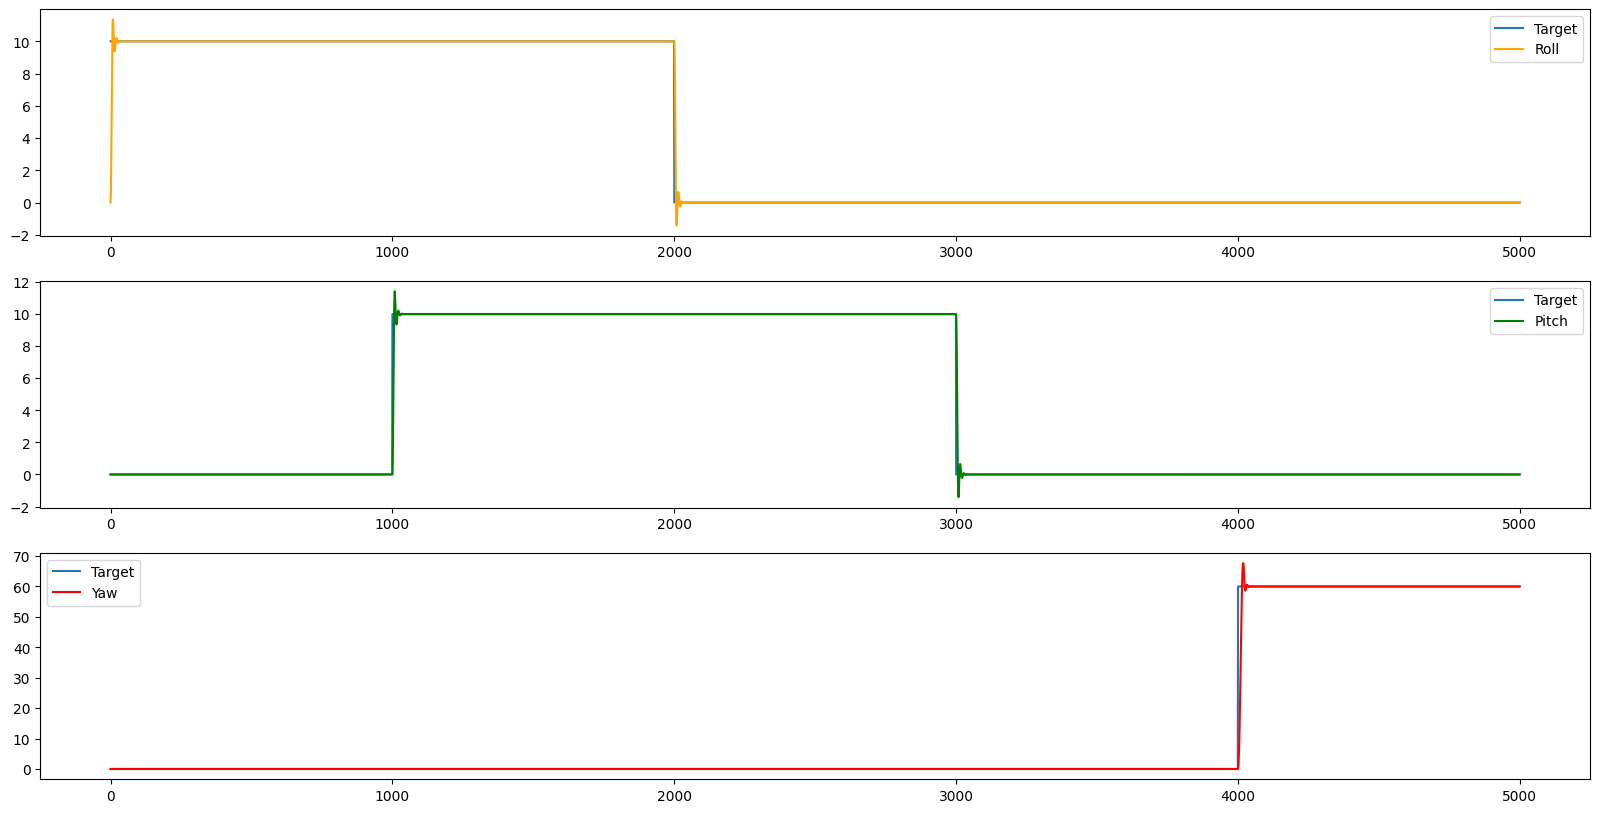

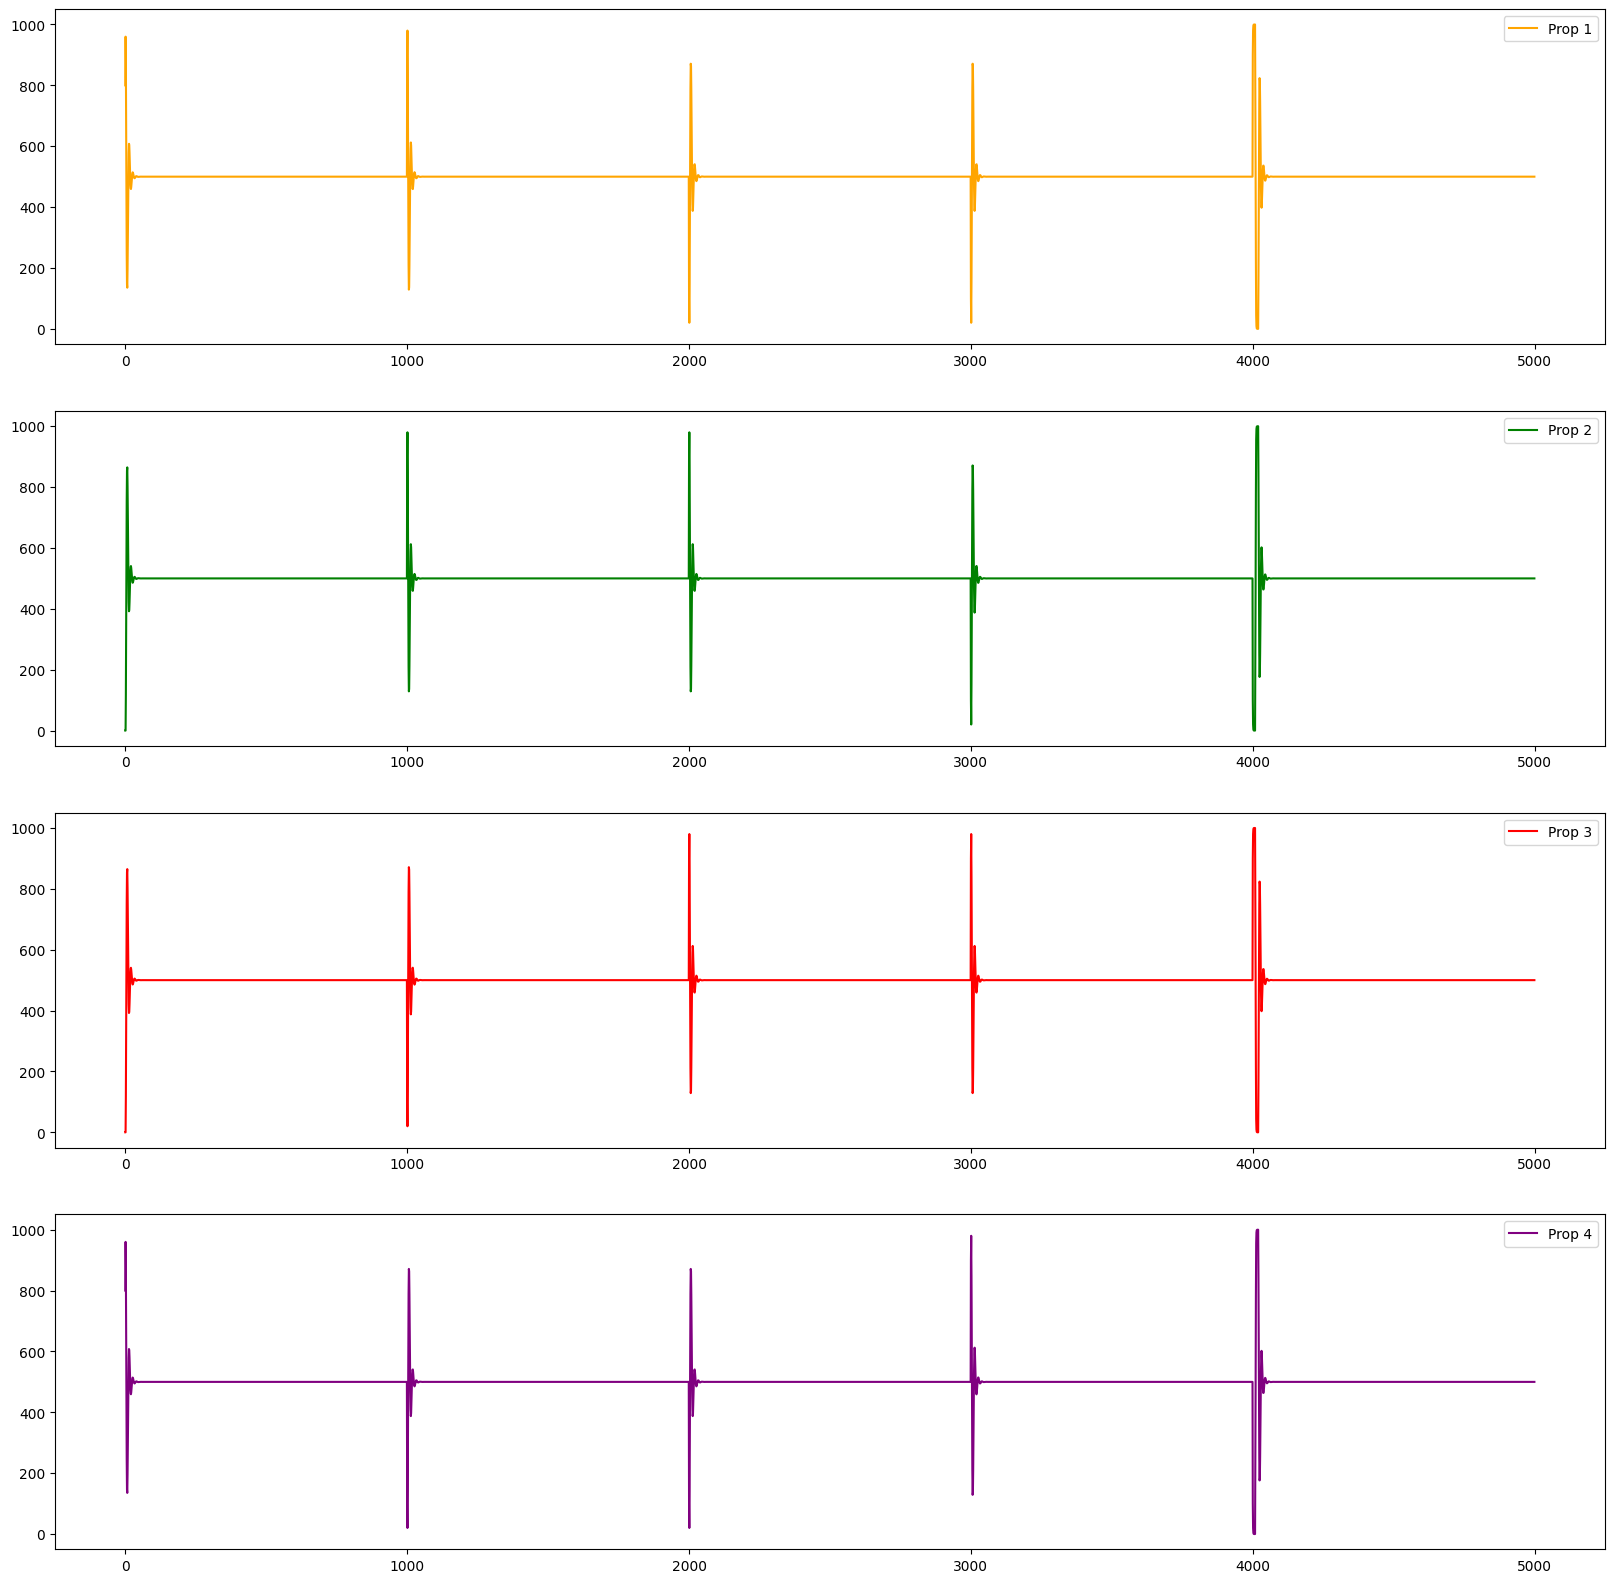

In [88]:
class QuadCopter:
    delta_time = 0.02 # 20ms
    arm_length = 0.2 # 0.2 m = 20 cm
    mass = 0.5 # 0.5Kg = 500g
    # TODO to be corrected
    moment_of_inertia = 1/12 * mass * (arm_length * 2) ** 2
    props = [
        Propeller(1),
        Propeller(-1),
        Propeller(1),
        Propeller(-1)
    ]

    # phi, theta, shi
    target_angle = np.array([0.0, 0.0, 0.0])
    angle = np.array([0.0, 0.0, 0.0])
    angular_velocity = np.array([0.0, 0.0, 0.0])
    
    # YPR = Yaw Pitch Roll
    # ψ = Yaw
    # ϕ = Roll
    # 𝜭 = Pitch
    
    # kp = np.array([20.0, 20.0, 20.0])
    # ki = np.array([0.0, 0.0, 0.0])
    # kd = np.array([2.7, 2.7, 2.7])
    # pid_i = np.array([0.0, 0.0, 0.0])
    # prev_error = np.array([0.0, 0.0, 0.0])

    # kp = np.array([30.0, 0.0, 0.0])
    # ki = np.array([0.0, 0.0, 0.0])
    # kd = np.array([2.65, 0.0, 0.0])
    # pid_i = np.array([0.0, 0.0, 0.0])
    # prev_error = np.array([0.0, 0.0, 0.0])

    kp = np.array([10.0, 10.0, 10.0])
    ki = np.array([0.0, 0.0, 0.0])
    kd = np.array([0.9, 0.9, 0.9])
    pid_i = np.array([0.0, 0.0, 0.0])
    prev_error = np.array([0.0, 0.0, 0.0])

    conversion_matrix = 0.05 * np.array([
        [  1, -1, -1,  1],
        [  1,  1, -1, -1],
        [  1, -1,  1, -1],
        [  1,  1,  1,  1],
    ])

    def update(self):
        throttle = 500
        if throttle > 800:
            throttle = 800
        elif throttle < 0:
            throttle = 0
            
        throttle /= 5
        # calculate PID
        error = self.target_angle - self.angle
        pid_p = self.kp * error
        delta_error = error - self.prev_error
        
        for i in range(self.pid_i.shape[0]):
            if abs(delta_error[i]) < 2:
                self.pid_i[i] += self.ki[i] * error[i] * self.delta_time
            else:
                self.pid_i[i] = 0

        pid_d = self.kd * delta_error / self.delta_time
        self.prev_error = error
        pid = pid_p + self.pid_i + pid_d

        # calculate motor speed
        motor_speed = np.linalg.inv(self.conversion_matrix) @ np.array([pid[0], pid[1], pid[2], throttle])
        # print(motor_speed[3])
        for i in range(len(self.props)):
            self.props[i].set_speed(motor_speed[i])

        # calculate physics
        # -----------------------------------------------------------

        # net_torque = self.conversion_matrix @ np.array([((p.speed / p.max_speed) ** 2) for p in self.props])
        net_torque = self.conversion_matrix @ np.array([p.get_thrust() for p in self.props])
        
        angular_acceleration = net_torque[:3] / self.moment_of_inertia
        self.angular_velocity = self.angular_velocity + angular_acceleration * self.delta_time
        for i in range(self.angular_velocity.shape[0]):
            if abs(self.angular_velocity[i]) > 300:
                direction = 1
                if self.angular_velocity[i] < 0:
                    direction = -1
                self.angular_velocity[i] = 300 * direction
                
        self.angle = self.angle + self.angular_velocity * self.delta_time

        # thrust calculation
        net_thrust = net_torque[3]
        gravitional_acceleration = np.array([0.0, 0.0, - self.mass * constants.g])

        

        for p in self.props:
            p.update(self.delta_time)



# -----------------------------------------------------------
quad = QuadCopter()
data = []
data_props = []

quad.target_angle = np.array([10, 0, 0])
for _ in range(1000):
    quad.update()
    data.append([quad.target_angle.copy(), quad.angle.copy()])
    data_props.append([p.speed for p in quad.props])

quad.target_angle = np.array([10, 10, 0])
for _ in range(1000):
    quad.update()
    data.append([quad.target_angle.copy(), quad.angle.copy()])
    data_props.append([p.speed for p in quad.props])


quad.target_angle = np.array([0, 10, 0])
for _ in range(1000):
    quad.update()
    data.append([quad.target_angle.copy(), quad.angle.copy()])
    data_props.append([p.speed for p in quad.props])


quad.target_angle = np.array([0, 0, 0])
for _ in range(1000):
    quad.update()
    data.append([quad.target_angle.copy(), quad.angle.copy()])
    data_props.append([p.speed for p in quad.props])



quad.target_angle = np.array([0, 0, 60])
for _ in range(1000):
    quad.update()
    data.append([quad.target_angle.copy(), quad.angle.copy()])
    data_props.append([p.speed for p in quad.props])


# for _ in range(10000):
#     quad.update()
#     data.append([quad.target_angle.copy(), quad.angle.copy()])
#     data_props.append([p.speed for p in quad.props])


data = np.array(data)
data_props = np.array(data_props)
colors = ['orange', 'green', 'red', 'purple', 'hotpink']
angles = ['Roll', 'Pitch', 'Yaw']
plt.figure(figsize=(20, 10))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(data[:, 0, i])
    plt.plot(data[:, 1, i], color=colors[i])
    plt.legend(['Target', angles[i]])
# plt.plot(data[:, 1, 1])
# plt.plot(data[:, 1, 2])
# plt.legend(['target', 'Roll', 'Pitch', 'Yaw'])
plt.show()

plt.figure(figsize=(20, 20))
for i in range(data_props.shape[1]):
    plt.subplot(4, 1, i+1)
    plt.plot(data_props[:, i], color=colors[i])
    plt.legend([f'Prop {i+1}'])
plt.show()
